
# Семинар 7 (part1): GradCam

В рамках данного семинара рассмотрим подробно модуль lightning.pytorch. Обучим классификационную сеть на датасете СARS196, который является бенчмарком для задачи metric-learning: https://paperswithcode.com/sota/metric-learning-on-cars196

Данные можно найти по ссылкам:
* meta : https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing
* data : https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing

А также рассмотрим библиотеку GradCam для интерпретации работы моделей компьютерного зрения:
repo - https://github.com/jacobgil/pytorch-grad-cam
paper - https://arxiv.org/abs/1610.02391

In [48]:
# --- Загрузка данных через gdown для Colab и локального запуска ---
import os
import sys
import zipfile

DEVKIT_ID = "1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7"
DATA_ID = "1l9EnYMC-xGX706SY1kN8RceMmFViASfx"

DEVKIT_DIR = "./devkit"
DEVKIT_ZIP = os.path.join(DEVKIT_DIR, "devkit.zip")
CARS_TRAIN_DIR = "./cars_train"
CARS_TRAIN_ZIP = os.path.join(CARS_TRAIN_DIR, "cars_train.zip")
CARS_TRAIN_EXTRACTED = os.path.join(CARS_TRAIN_DIR, "cars_train")

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

import gdown

def download_and_unzip(file_id, zip_path, extract_dir):
    os.makedirs(os.path.dirname(zip_path), exist_ok=True)
    if not os.path.exists(zip_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Скачиваем {zip_path}...")
        gdown.download(url, zip_path, quiet=False)
    else:
        print(f"{zip_path} уже скачан.")
    # Распаковка
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Распаковано в {extract_dir}")

# Скачиваем и распаковываем devkit
if not (os.path.exists(os.path.join(DEVKIT_DIR, "cars_train_annos.mat")) and os.path.exists(os.path.join(DEVKIT_DIR, "cars_meta.mat"))):
    download_and_unzip(DEVKIT_ID, DEVKIT_ZIP, DEVKIT_DIR)
else:
    print("devkit уже распакован.")

# Скачиваем и распаковываем cars_train
if not (os.path.exists(CARS_TRAIN_EXTRACTED) and len(os.listdir(CARS_TRAIN_EXTRACTED)) > 1000):
    download_and_unzip(DATA_ID, CARS_TRAIN_ZIP, CARS_TRAIN_DIR)
else:
    print("cars_train уже распакован.")

./devkit/devkit.zip уже скачан.
Распаковано в ./devkit
./cars_train/cars_train.zip уже скачан.
Распаковано в ./cars_train


In [49]:
!pip install -q typing_extensions torch torchvision lightning pytorch-lightning timm faiss-cpu opencv-python-headless grad-cam gdown

In [50]:
import torch, sys, subprocess
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current_device:", torch.cuda.current_device())
    print("device name:", torch.cuda.get_device_name(0))
print("python executable:", sys.executable)

torch.__version__: 2.5.1+cu124
torch.version.cuda: 12.4
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
current_device: 0
device name: Tesla T4
python executable: /usr/bin/python3


In [51]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer_accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print(f"Using device={device}, trainer_accelerator={trainer_accelerator}")

Using device=cuda, trainer_accelerator=gpu


In [52]:
import scipy.io
mat = scipy.io.loadmat('./devkit/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [53]:
ADD_PATH = './cars_train/cars_train/cars_train'

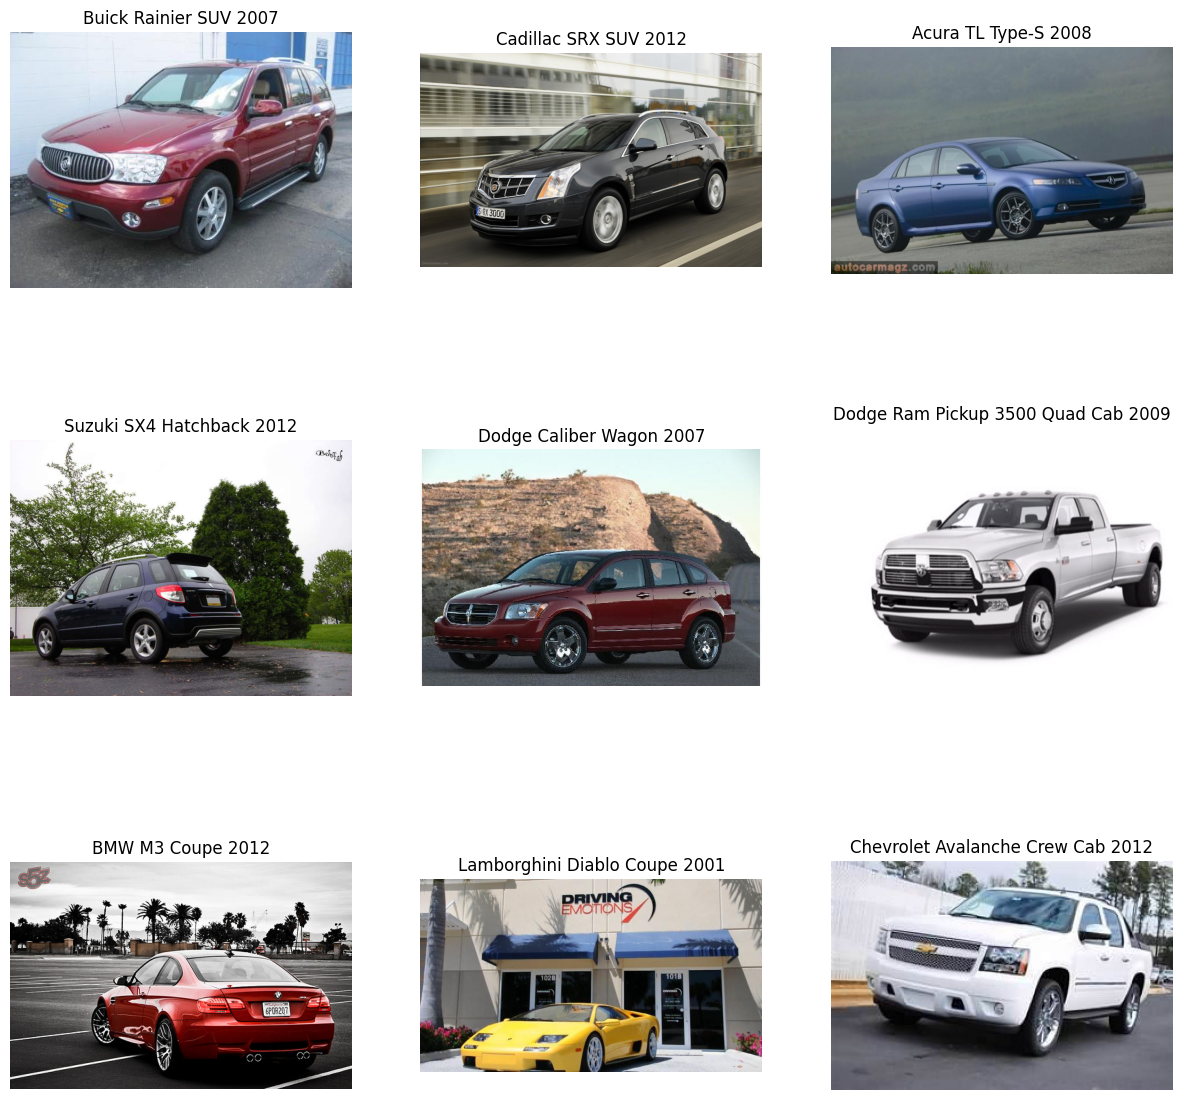

In [54]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    img_path = os.path.join(ADD_PATH, filename)
    temp_image = cv2.imread(img_path)
    if temp_image is None:
        print(f"[WARNING] Не удалось загрузить изображение: {img_path}")
        ax[idx//cols][idx%cols].set_title(f'NOT FOUND: {filename}')
        ax[idx//cols][idx%cols].axis('off')
        continue
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

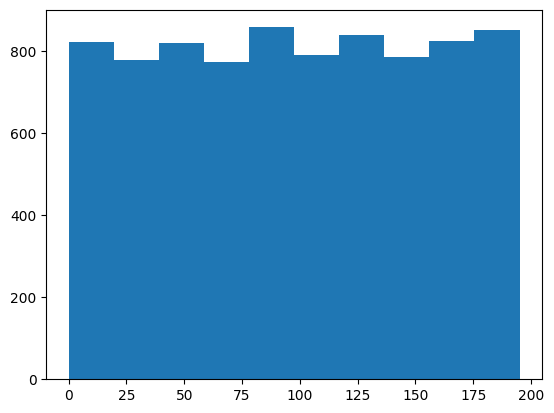

In [55]:
plt.hist(fname_to_class.values())
plt.show()

### Реализуем обертку для данных

In [56]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# аугментация
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id, 'fname': filename}
        return sample

In [57]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [58]:
from collections import defaultdict
def make_batch_sampler(items, batch_size, num_pos=4):
    cls_to_idxs = defaultdict(list)
    for idx, (_, cl) in enumerate(items):
        cls_to_idxs[cl].append(idx)
    unique_classes = list(cls_to_idxs.keys())
    def generator():
        while True:
            batch = []
            classes = random.sample(unique_classes, batch_size // num_pos)
            for c in classes:
                chosen = random.choices(cls_to_idxs[c], k=num_pos)
                batch.extend(chosen)
            yield batch
    return generator()

batch_size = 64
num_pos = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

### Обучим модель

In [59]:
from timm import create_model
from timm.scheduler import TanhLRScheduler
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import faiss

import numpy as np

def precision_at_k(relevant, retrieved, k):
    retrieved_k = retrieved[:k]
    return len([r for r in retrieved_k if r in relevant]) / k


def recall_at_k(relevant, retrieved, k):
    retrieved_k = retrieved[:k]
    if len(relevant) == 0:
        return 0.0
    return len([r for r in retrieved_k if r in relevant]) / len(relevant)


def average_precision(relevant, retrieved):
    hits = 0
    sum_prec = 0.0
    for i, r in enumerate(retrieved, start=1):
        if r in relevant:
            hits += 1
            sum_prec += hits / i
    if hits == 0:
        return 0.0
    return sum_prec / hits


class EmbeddingNet(pl.LightningModule):
    def __init__(self, emb_size=512, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')
        feat_dim = getattr(self.backbone, 'num_features', None)
        if feat_dim is None:
            self.backbone.eval()
            with torch.no_grad():
                dummy = torch.zeros(1, 3, 224, 224)
                out = self.backbone(dummy)
            feat_dim = out.shape[1]
        self.embed = torch.nn.Linear(int(feat_dim), emb_size)
        self.lr = lr
        self.margin = 0.3
        self._val_embeddings = []
        self._val_labels = []

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embed(feats)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        return emb

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return opt

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        loss = batch_hard_triplet_loss(embeddings, labels, margin=self.margin)
        self.log('train_triplet_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_start(self):
        self._val_embeddings = []
        self._val_labels = []

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        self._val_embeddings.append(embeddings.detach().cpu())
        self._val_labels.append(labels.detach().cpu())
        return None

    def on_validation_epoch_end(self):
        if len(self._val_embeddings) == 0:
            return
        embs = torch.cat(self._val_embeddings, dim=0).numpy().astype('float32')
        labels = torch.cat(self._val_labels, dim=0).numpy()
        index = faiss.IndexFlatL2(embs.shape[1])
        index.add(embs)
        k = 5
        D, I = index.search(embs, k+1)
        precisions = []
        recalls = []
        aps = []
        for i in range(embs.shape[0]):
            retrieved = [int(idx) for idx in I[i] if idx != i][:k]
            relevant = set(np.where(labels == labels[i])[0].tolist()) - {i}
            precisions.append(precision_at_k(relevant, retrieved, k))
            recalls.append(recall_at_k(relevant, retrieved, k))
            aps.append(average_precision(relevant, retrieved))
        self.log('val_precision@k', float(np.mean(precisions)), prog_bar=True)
        self.log('val_recall@k', float(np.mean(recalls)), prog_bar=True)
        self.log('val_map', float(np.mean(aps)), prog_bar=True)


def pairwise_distance(embeddings):
    dot = torch.matmul(embeddings, embeddings.t())
    sq_norm = torch.diag(dot)
    dist = sq_norm.unsqueeze(1) - 2.0 * dot + sq_norm.unsqueeze(0)
    dist = torch.clamp(dist, min=0.0)
    return dist


def batch_hard_triplet_loss(embeddings, labels, margin=0.3):
    dist = pairwise_distance(embeddings)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.t())
    pos_dist = dist.clone()
    pos_dist[~mask_pos] = -1e12
    hardest_pos = pos_dist.max(dim=1)[0]
    max_dist = dist.max().item() if dist.numel() > 0 else 0.0
    dist_neg = dist + max_dist * mask_pos.float()
    hardest_neg = dist_neg.min(dim=1)[0]
    loss = torch.relu(hardest_pos - hardest_neg + margin).mean()
    return loss

In [60]:
pl_model = EmbeddingNet(emb_size=512, lr=3e-4)
checkpoint_callback = ModelCheckpoint(monitor='val_map', mode='max', save_top_k=3)
# last_checkpoint = ModelCheckpoint(mode='max', monitor='time_log', save_top_k=1)

early_stopping = EarlyStopping(monitor="val_map", mode="max", patience=3)
lr_monitor = LearningRateMonitor(logging_interval='step')

available_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1
trainer = pl.Trainer(max_epochs=20, accelerator=trainer_accelerator, devices=available_devices, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [61]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type         | Params | Mode 
--------------------------------------------------
0 | backbone | EfficientNet | 4.0 M  | train
1 | embed    | Linear       | 655 K  | train
--------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type         | Params | Mode 
--------------------------------------------------
0 | backbone | EfficientNet | 4.0 M  | train
1 | embed    | Linear       | 655 K  | train
--------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
338       Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [62]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_map          │    0.6351408362388611     │
│      val_precision@k      │    0.4467771649360657     │
│       val_recall@k        │    0.28348809480667114    │
└───────────────────────────┴───────────────────────────┘

[{'val_precision@k': 0.4467771649360657,
  'val_recall@k': 0.28348809480667114,
  'val_map': 0.6351408362388611}]

# GradCam

In [63]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import faiss

In [67]:
transform_to_show = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    torchvision.transforms.ToTensor()
])

def show_grad_cam(model, num_imgs):
    model = model.to(device)
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    # подготовим эталонные эмбеддинги и метки для поиска ближайшего класса
    ref_embs = []
    ref_labels = []
    with torch.no_grad():
        for batch in valid_loader:
            images = batch['image'].to(device)
            labels = batch['label']
            embs = model(images)
            ref_embs.append(embs.cpu())
            ref_labels.append(labels.cpu())
    ref_embs = torch.cat(ref_embs, dim=0).numpy().astype('float32')
    ref_labels = torch.cat(ref_labels, dim=0).numpy()
    index = faiss.IndexFlatL2(ref_embs.shape[1])
    index.add(ref_embs)
    # визуализация
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        filename, cl_id = list(fname_to_class.items())[im_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [getattr(model, 'conv_head', list(model.children())[-1])]
        cam = GradCAM(model=model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        # ищем ближайший эталонный класс по faiss
        with torch.no_grad():
            emb = model(transformed_im).cpu().numpy().astype('float32')
            D, I = index.search(emb, 2)  # 2, чтобы не вернуть сам себя
            # Берём ближайший не сам себя
            pred_idx = I[0][1] if I[0][0] == im_idx else I[0][0]
            pred_class = ref_labels[pred_idx]
            pred = id_to_car[pred_class] if pred_class in id_to_car else f"class {pred_class}"
        ax[idx//cols][idx%cols].imshow(visualization)
        ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')

def show_diff_grad_methods(model, methods):
    model = model.to(device)
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [getattr(model, 'conv_head', list(model.children())[-1])]
            cam = method(model=model, target_layers=target_layers)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')


### посмотрим на различные методы

100%|██████████| 40/40 [00:01<00:00, 23.36it/s]


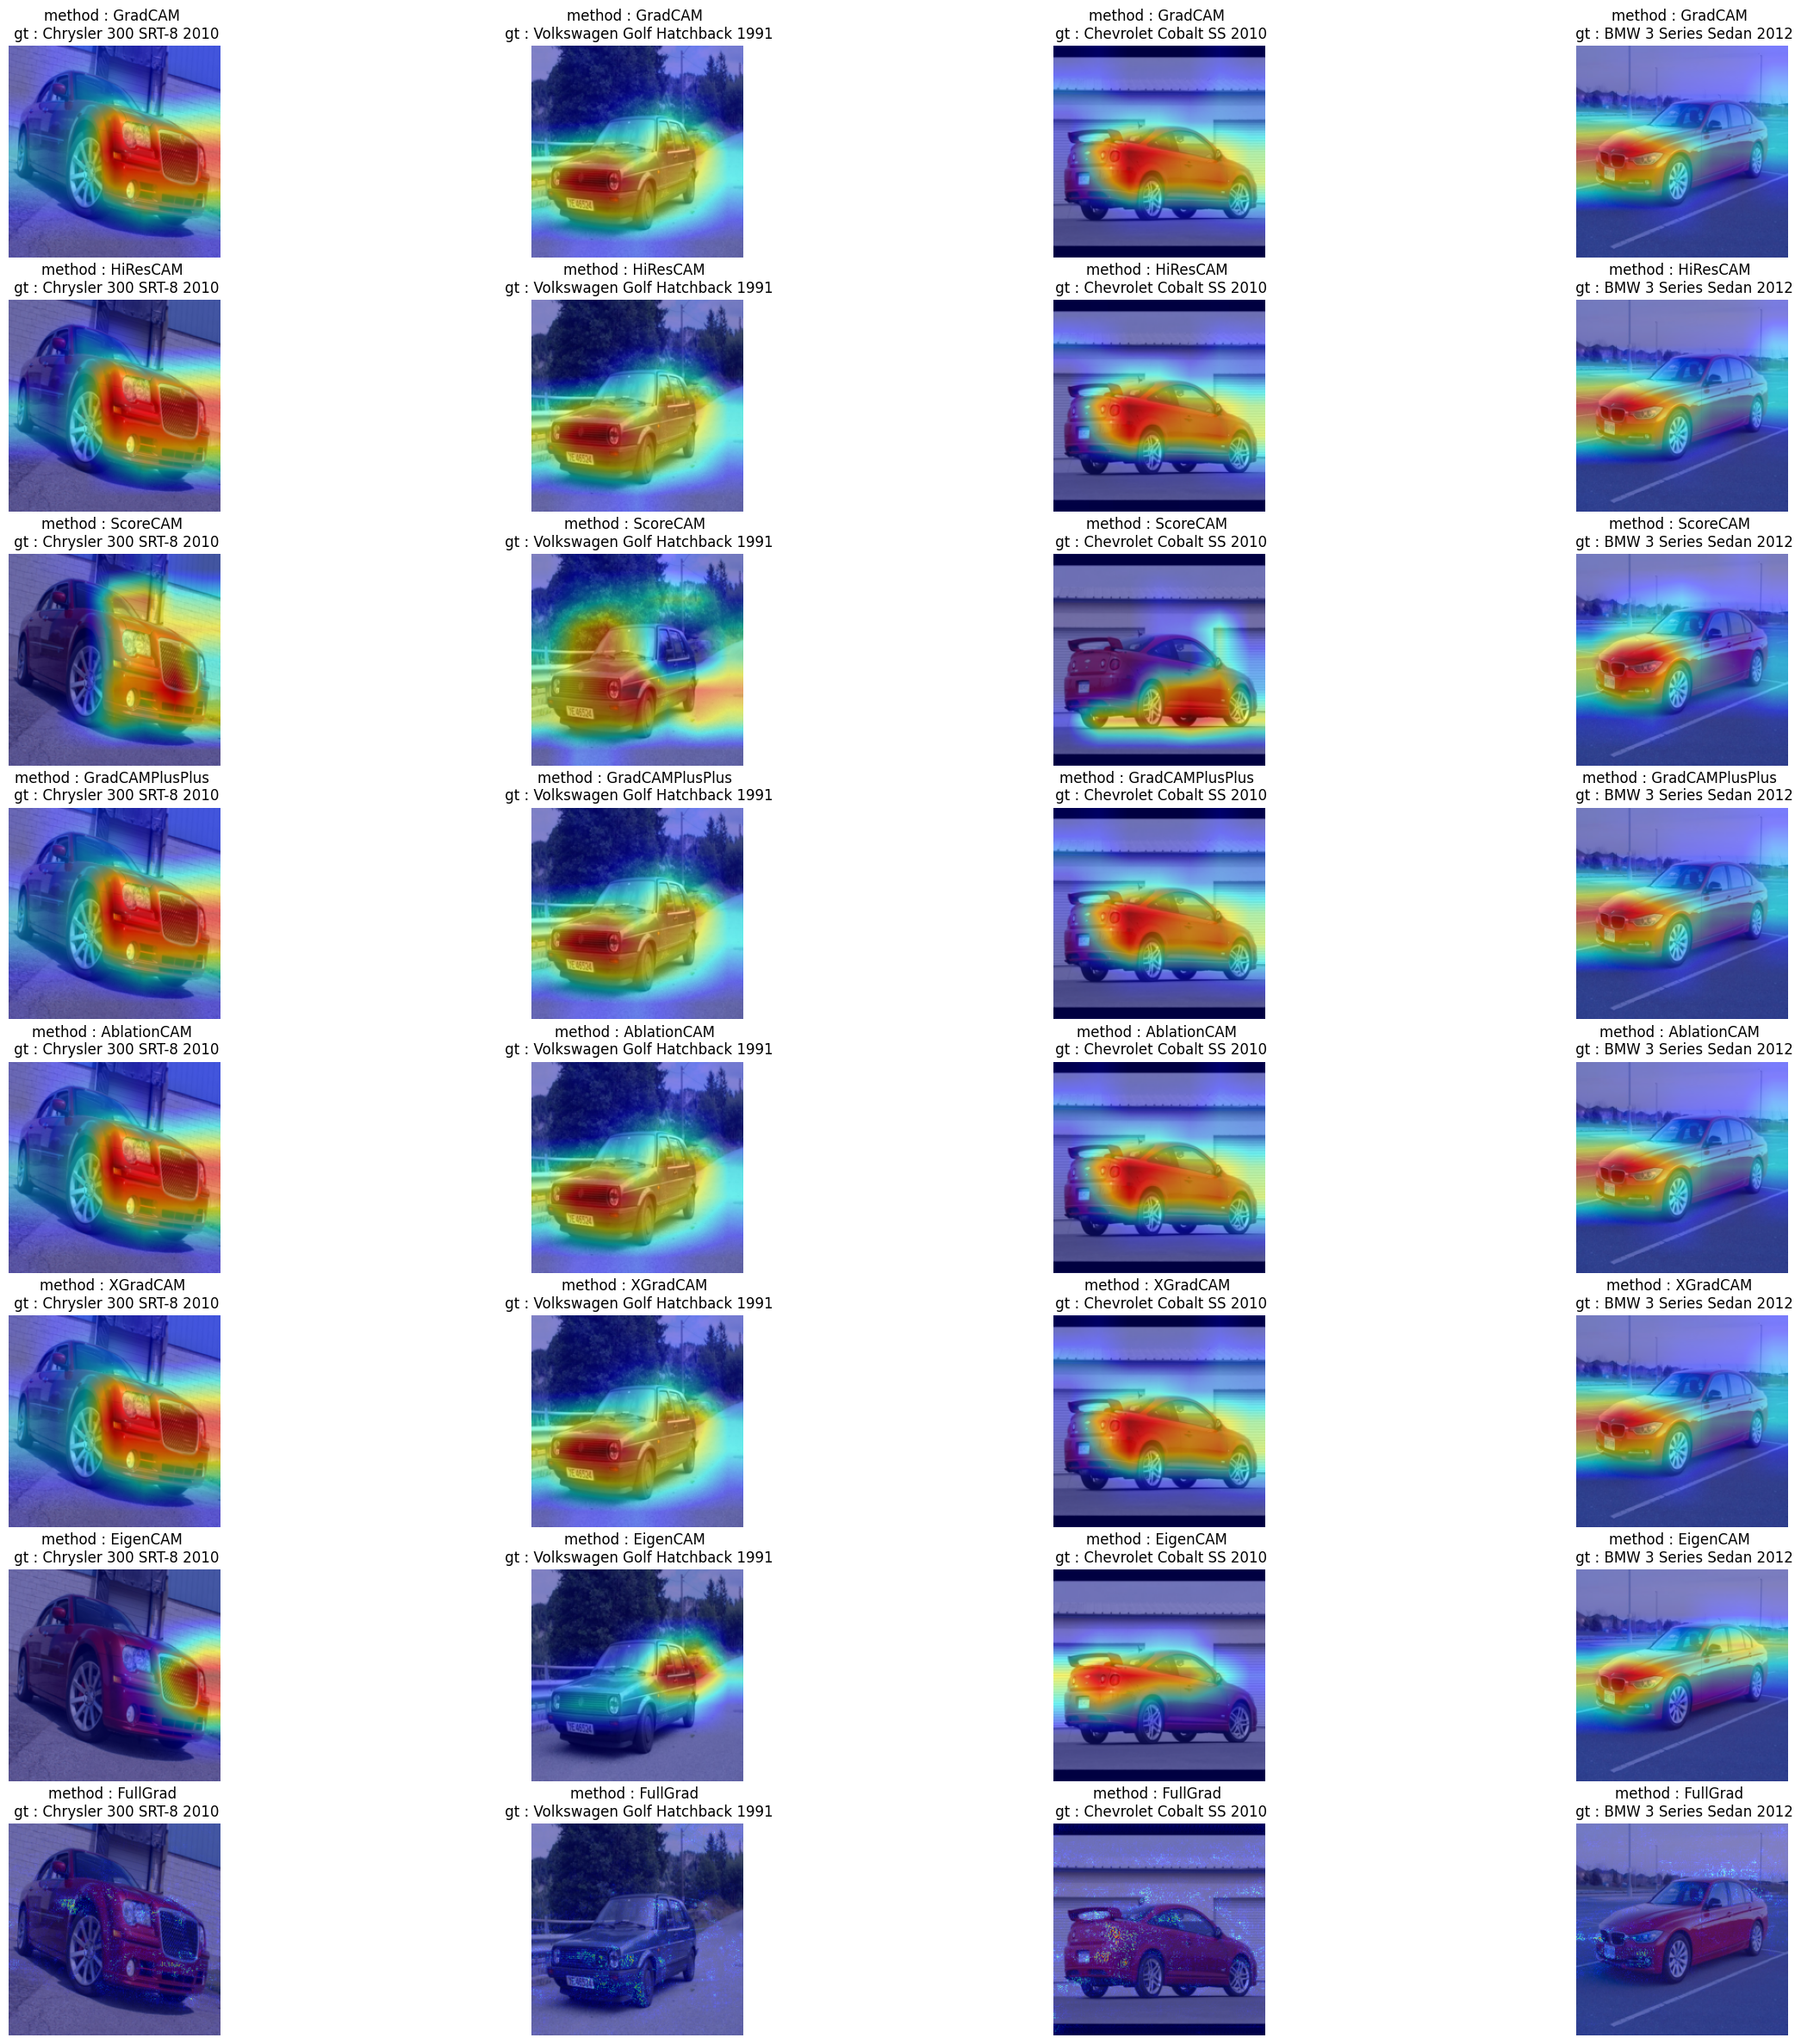

In [65]:
show_diff_grad_methods(pl_model.backbone, [GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad])

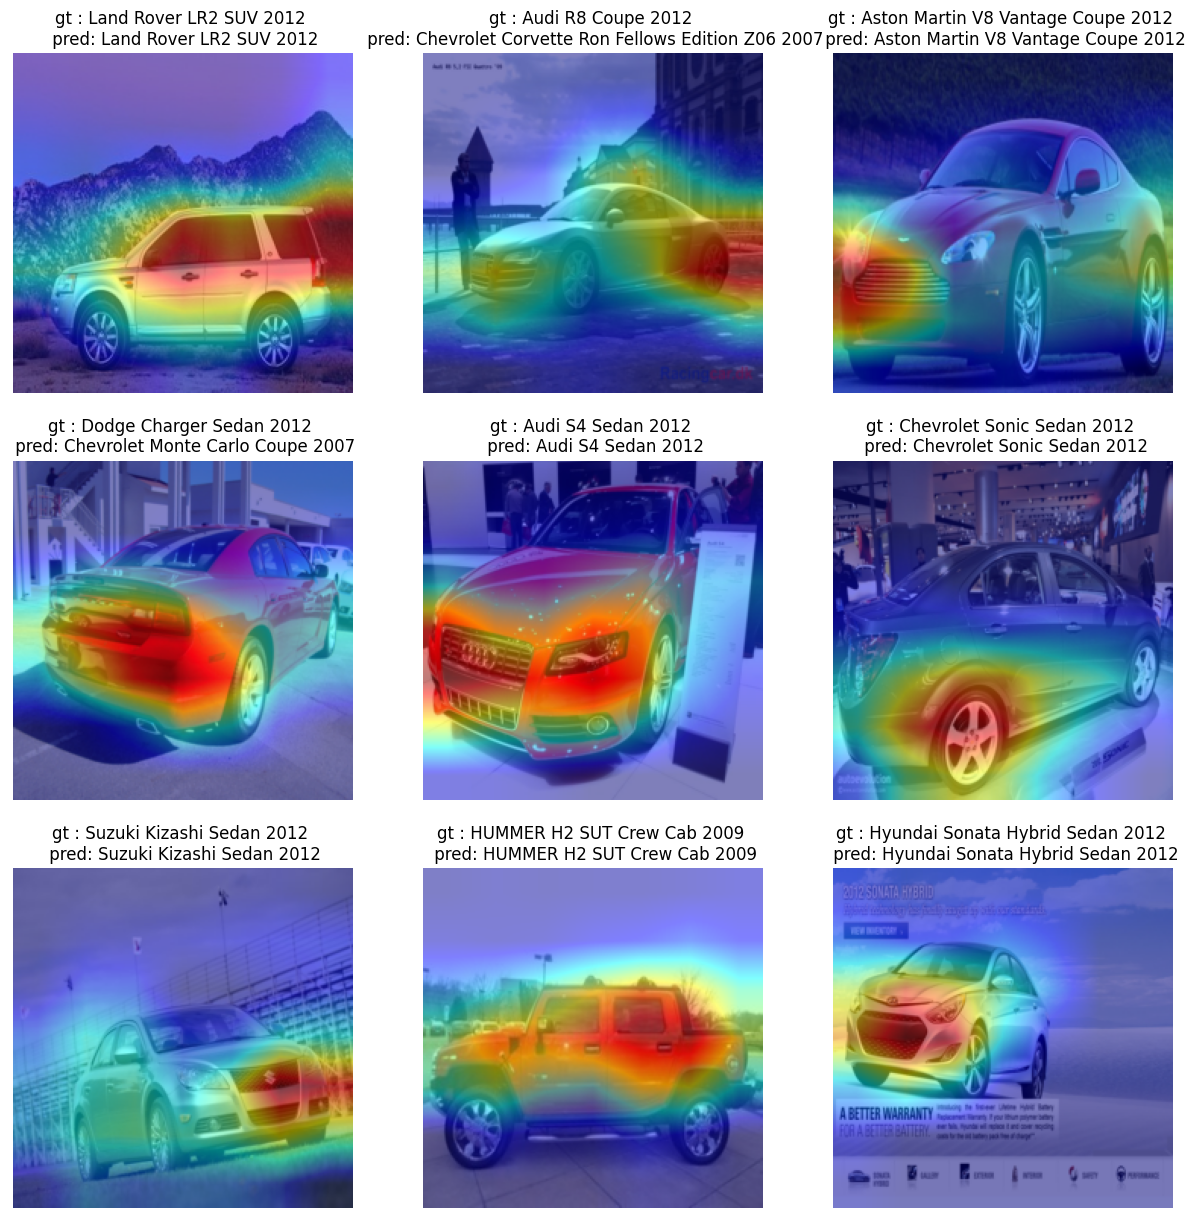

In [68]:
show_grad_cam(pl_model.backbone, num_imgs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


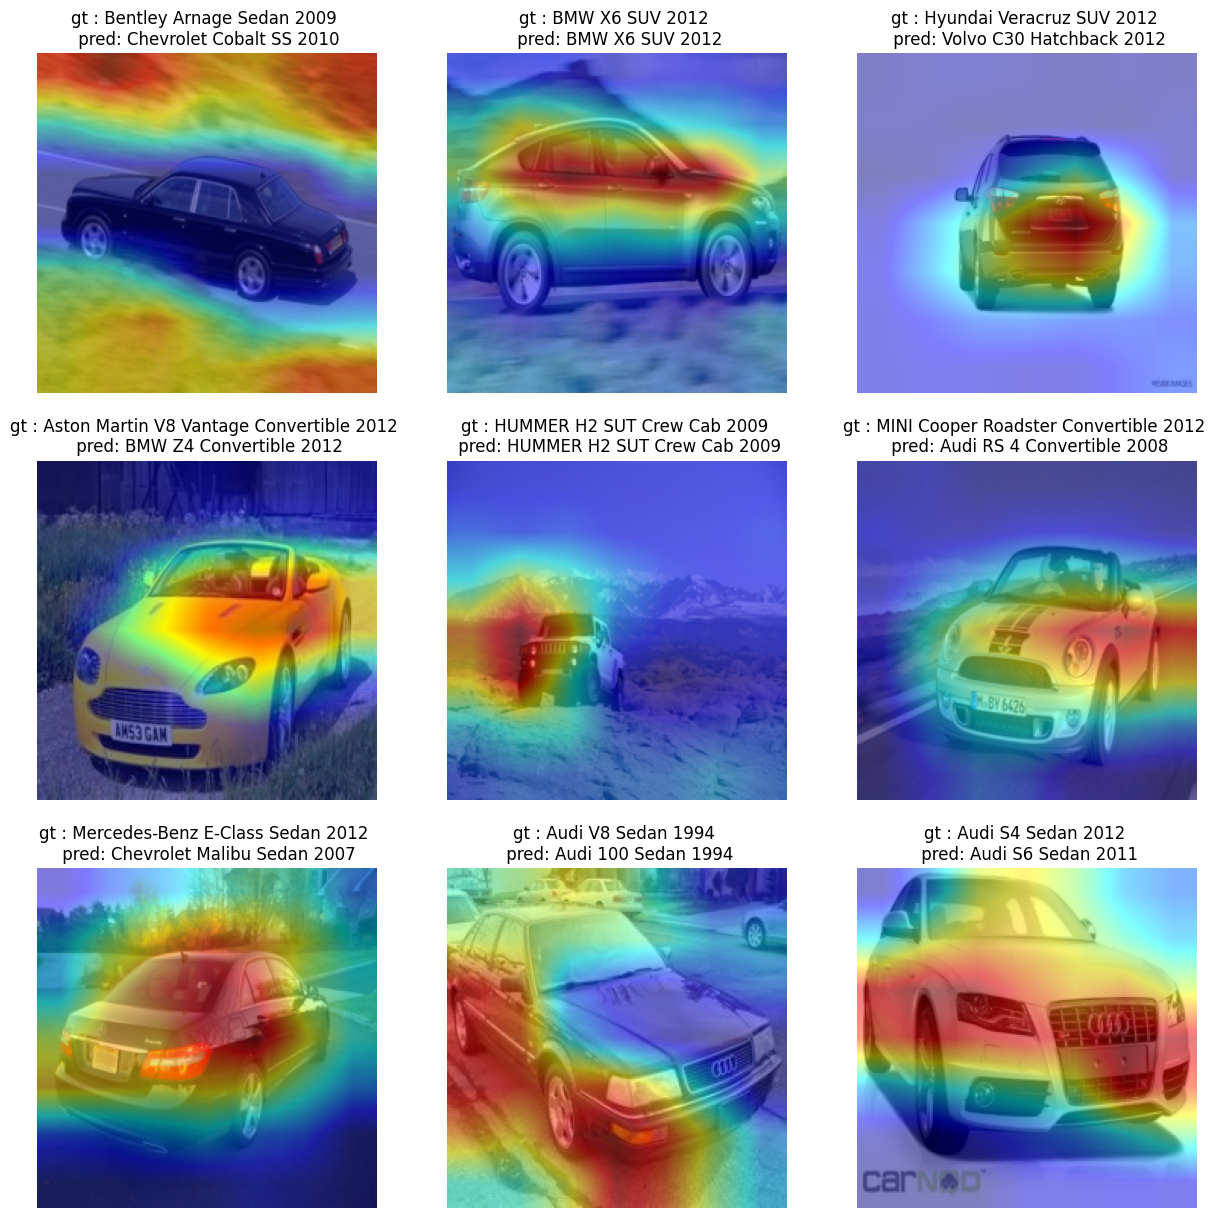

In [72]:
t = EmbeddingNet(emb_size=512, lr=3e-4)
show_grad_cam(t.backbone, num_imgs)